In [10]:
############################### Importing Libraries ######################################

import pymssql
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
import sqlalchemy
from sqlalchemy  import create_engine
import matplotlib.pyplot as plt

In [5]:
############################### Database Connections ######################################
# AWS
#server = 'pfidb.ci3ir6nuotoi.sa-east-1.rds.amazonaws.com'
#user = 'admin'
#password = 'AramLucas2020.'
#db = 'pfidb'

# Local DB PC
server = 'DESKTOP-3OHRULK'
user = 'sa'
password = 'welcome1'
db = 'pfidb'

# Connection to DB
conn = pymssql.connect(server,user,password,db)

#Connection using sqlAlchemy
conn_for_insert = fr'mssql+pymssql://'+user+':'+password+'@'+server+'/'+db
engine = create_engine(conn_for_insert)

In [6]:
#Query that retrives the usage of the stations
query = open("master_query_v3.sql","r")
df_stations_usage = pd.read_sql_query(query.read(),conn)

stations_query = """SELECT * FROM [estaciones-de-bicicletas-publicas]"""
df_stations = pd.read_sql(stations_query,conn)


In [7]:
#######################################################
# Determine % of usage of the stations
#######################################################
df_stations_usage["percentage_of_usage"] = (df_stations_usage["diferencia"]/df_stations_usage["capacidad"])*100
df_stations_usage = df_stations_usage[["nombre","nro_est","lat","long","percentage_of_usage","return_datetime"]]
df_stations_usage['return_datetime']=df_stations_usage['return_datetime'].astype('datetime64[s]')
df_stations_usage.rename(columns={'return_datetime': 'datetime'}, inplace=True)
df_stations_usage = df_stations_usage.sort_values(by=["percentage_of_usage"], ascending=True)

         K           sse
0      1.0  1.622321e-01
1      2.0  7.695493e-02
2      3.0  5.225927e-02
3      4.0  3.858041e-02
4      5.0  2.990849e-02
..     ...           ...
193  194.0  1.455832e-06
194  195.0  5.937185e-07
195  196.0  5.175386e-08
196  197.0  1.608660e-08
197  198.0  7.270601e-09

[198 rows x 2 columns]


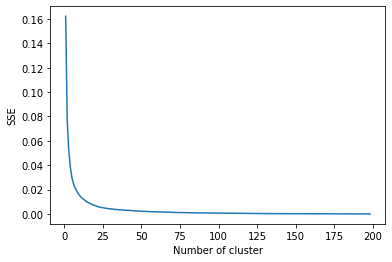

In [57]:
lat_long = df_stations[["lat", "long"]].values
sse_df = pd.DataFrame(columns=['K','sse'])
sse = {}
for k in range(1, int(len(df_stations))):
    kmeans = KMeans(n_clusters=k,random_state=0,max_iter=1000).fit(lat_long)
    sse_df = sse_df.append({'K':k, 'sse':kmeans.inertia_},ignore_index=True)
    sse[k] = kmeans.inertia_
print(sse_df)
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()
#df = pd.DataFrame({'cluster':range(0,K), 'lat_centroide':kmeans.cluster_centers_[:,0],'long_centroide':kmeans.cluster_centers_[:,1]})
#df_mergeado = pd.merge(df_stations,pd.DataFrame(kmeans.labels_),left_index=True,right_index=True)
#df_mergeado = pd.merge(df_mergeado,df,how='left',left_on=0,right_on='cluster')
#df_mergeado = df_mergeado.drop(0,axis=1)
#df_mergeado.rename(columns={"cluster_x": "cluster", "lat_centroide_x": "lat_centroide", "long_centroide_x": "long_centroide"})


In [44]:
sse_df['variation'] = (sse_df['sse'].pct_change())*-1
i = sse_df.loc[(sse_df['variation'] <= 0.1)].index[0]
lower_limit = int(sse_df.iloc[i]['K'])
upper_limit = int(lower_limit  + round((len(df_stations)*0.1)))
print(upper_limit)

30


In [46]:
silhouette = pd.DataFrame(columns=['cluster','sil_coeff'])
for n_cluster in range(lower_limit, upper_limit):
    kmeans = KMeans(n_clusters=n_cluster).fit(lat_long)
    label = kmeans.labels_
    sil_coeff = silhouette_score(lat_long, label, metric='euclidean')
    silhouette = silhouette.append({'cluster':n_cluster, 'sil_coeff':sil_coeff},ignore_index=True)
    #print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
silhouette

,cluster,sil_coeff
0,10.0,0.337521
1,11.0,0.331234
2,12.0,0.341566
3,13.0,0.322989
4,14.0,0.339285
5,15.0,0.343914
6,16.0,0.332142
7,17.0,0.325362
8,18.0,0.345822
9,19.0,0.352268


In [52]:
silhouette.loc[silhouette['sil_coeff'].idxmax()]['cluster']

28.0

Automatically created module for IPython interactive environment
For n_clusters = 28 The average silhouette_score is : 0.3357808576631602


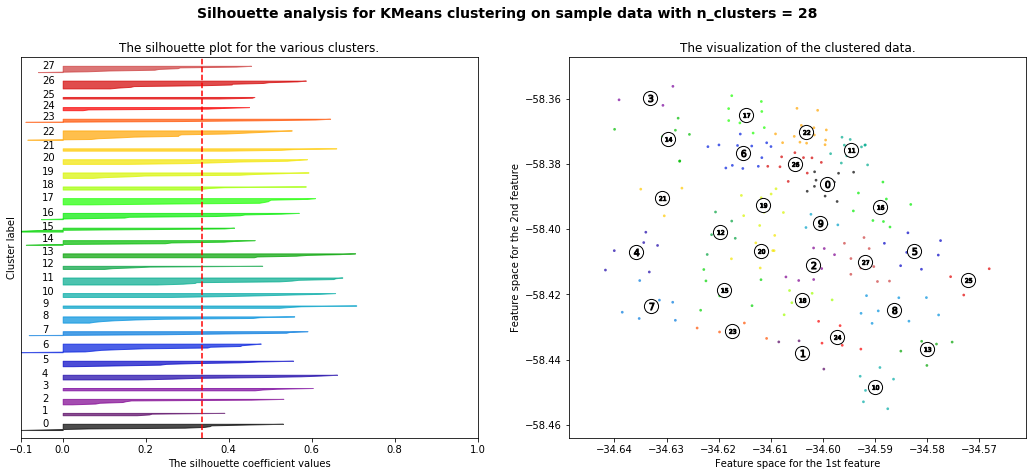

In [56]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
k_to_use = int(silhouette.loc[silhouette['sil_coeff'].idxmax()]['cluster'])
range_n_clusters = [k_to_use]
X = df_stations[["lat", "long"]].values

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()